# Ocean regime prediction with Bayesian neural networks

**Author**: [Mariana Clare](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/mariana-clare)

*This notebook was last tested and operational on 16/06/2025. Please [report any issues](https://github.com/ecmwf-training/ml-examples/issues).*

:::{admonition} About
:class: note, dropdown
This notebook was originally created for ECMWF's [MOOC on Machine Learning in Weather and Climate](https://learning.ecmwf.int/course/index.php?categoryid=1), and has been lightly updated and tested for the purposes of this collection of examples. The original notebook can be found [here](https://github.com/ecmwf-training/mooc-machine-learning-weather-climate/blob/main/tier_2/uncertainty/solution_using_a_bnn_for_probabilistic_ocean_regime_predictions.ipynb).

The work in this notebook is based on [Clare et al. (2022) *Explainable Artificial Intelligence for Bayesian Neural Networks: Toward Trustworthy Predictions of Ocean Dynamics*](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022MS003162). This in turn builds on work in [Sonnewald & Lguensat (2021)](https://doi.org/10.1029/2021MS002496) who built a deterministic neural network for the same problem and [Sonnewald et al. (2019)](https://doi.org/10.1029/2018ea000519), where the ocean regimes were first identified by k-means clustering.
:::

:::{admonition} Running this notebook
:class: tip, dropdown
This notebook can be run/accessed on the following free online platforms. Please note they are not officially supported by or linked with ECMWF. See [Running the notebooks](sec:running_notebooks) for more details.

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/ml-examples/blob/develop/ex_BNN_Ocean_Regimes.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/ml-examples/blob/develop/ex_BNN_Ocean_Regimes.ipynb)
[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/ml-examples/develop?labpath=ex_BNN_Ocean_Regimes.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/ml-examples/blob/develop/ex_BNN_Ocean_Regimes.ipynb)

:::

## Introduction

In this notebook we will use a Bayesian neural network (BNN) to probabilistically classify ocean gridpoints into ocean circulation regimes.

A Bayesian neural network (BNN) is a type of neural network which treats the network parameters (weights and biases) as probability distributions rather than fixed estimates. As a result, predictions from a BNN a probabilistic (e.g. the probability of belonging to a particular class). BNNs are particularly useful for capturing uncertainty. They are typically trained by variational inference. See our [ML MOOC](https://learning.ecmwf.int/course/index.php?categoryid=1) (Tier 2, "Uncertainty and Generative Modelling module" for more details).

In this example we will use a set of input features (predictor variables) and the corresponding circulation regime labels, for each gridpoint, to train our model. We begin with a simple neural network, and add probabilistic features, to arrive at the full BNN. At the end of the notebook we also demonstrate how to analyse and visualise the uncertainty of the classifications from the BNN.

The input features for our neural network are as follows:

1.   Wind stress curl
2.   Mean Sea Surface Height (SSH) (20 years)
3.   Gradients of Mean Sea Surface Height
4.   Bathymetry
5.   Gradients of bathymetry
6.   Coriolis

For justification of this choice of these features please see [Sonnewald & Lguensat (2021)](https://doi.org/10.1029/2021MS002496).

## Set up your environment

We'll begin by loading the required packages. Importantly, tensorflow probability (which is what we will use to build the Bayesian neural networks) has an [incompatibility with the latest version of keras](https://github.com/tensorflow/probability/releases). For this reason, we will have to install specific versions of tensorflow, tensorflow probability, and keras. Depending on which platform you run this notebook on (e.g. Colab), you may be told to restart your runtime - this may look like an error, but restart and carry on - it should work!

In [ ]:
!pip install tensorflow==2.15.0
!pip install tensorflow-probability==0.23.0
!pip install keras==2.15.0

We'll now load the libraries just installed, and check the versions.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras as keras  # Make sure tf-keras==2.15.0 is installed

print("TensorFlow version:", tf.__version__)
print("TFP version:", tfp.__version__)
print("Keras version:", keras.__version__)
print("Keras package location:", keras.__file__)

TensorFlow version: 2.15.0
TFP version: 0.23.0
Keras version: 2.18.0
Keras package location: /usr/local/lib/python3.11/dist-packages/tf_keras/__init__.py


Finally, we will import the standard libraries for working with array data, and plotting.

In [ ]:
# 📊 Standard packages for data and plotting
import numpy as np
import xarray as xr
from scipy.io import loadmat
import matplotlib.pyplot as plt

## Download data

We now download the data, which is hosted on an ECMWF server. The following commands download:

* Labels for ocean circulation regimes
* Wind stress curl
* Sea surface height for years 1992-2011
* Bathymetry data

Some of these variables will be used directly as predictors, while further predictors will be created by operating on them. Notice that the files we download are in a mixture of file formats. This may take a few minutes to complete.



In [ ]:
## Download input Data
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/kCluster6.npy
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/curlTau.npy
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1992.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1993.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1994.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1995.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1996.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1997.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1998.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.1999.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2000.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2001.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2002.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2003.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2004.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2005.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2006.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2007.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2008.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2009.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2010.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/SSHdata/SSH.2011.nc
! wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_2/uncertainty/H_wHFacC.mat



## Create predictor and target variables

Currently, our data is inside downloaded files. We need to import it into Python, and apply some processing operations to create our cleaned data set ready for training and modelling.

We'll begin with our target variable - the ocean regimes labels. This simply requires importing the `.npy` file and replacing land pixels with NaNs.

In [ ]:
## Load in ocean regimes labels as target data. These ocean regimes were determined in Sonnewald et al. 2019
ecco_label = np.transpose(np.load('kCluster6.npy'))

# replace land pixels by NaNs
ecco_label[ecco_label==-1] = np.nan

We now move to the predictor variables. Two of our variables can be generated directly: *wind stress curl* by importing the data from a `.npy` (NumPy array) file, and *bathymetry* data from a MATLAB file.

In [ ]:
wind_stress_curl = np.transpose(np.load('curlTau.npy'))
bathymetry = np.transpose(loadmat('H_wHFacC.mat')['val'])

The next predictor variable, *mean sea surface height* (SSH), is created by reading in all `SSH.*` files (which are NetCDF files), combining by coordinates (using xarray), and then taking the mean at each coordinate.

In [ ]:
monthly_ssh = xr.open_mfdataset('SSH.*.nc', combine='by_coords')
SSH20mean = monthly_ssh['SSH'].mean(axis=0).values  # 20 years mean of sea surface height

Next we'll calculate the Coriolis parameter using the latitude values in the monthly SSH variable created previously. This is also included as a predictor variable.

In [ ]:
# get latitudes
lat = monthly_ssh['lat'].values

##coriolis
Omega=7.2921e-5 # coriolis parameter
f = (2*Omega*np.sin(lat*np.pi/180))

Finally, we'll create the gradients of SSH and bathymetry in the latitude and longitude directions. These gradients highlight spatial changes, which are relevant for understanding ocean circulation patterns.

In [ ]:
## Calculate the SSH gradients, bathymetry gradients and coriolis

lonRoll = np.roll(monthly_ssh['lat'].values, axis=0, shift=-1)
Londiff = lonRoll - monthly_ssh['lat'].values  # equivalent to doing x_{i} - x_{i-1}

latDiff=1.111774765625000e+05
latY=np.gradient(lat, axis=0)*latDiff
lonX=np.abs(np.cos(lat*np.pi/180))*latDiff*Londiff

def grad(d,y,x):
    grady=np.gradient(d, axis=0)/y
    gradx=np.gradient(d, axis=1)/x
    return grady, gradx

gradSSH_y, gradSSH_x = grad(SSH20mean,latY,lonX)
gradBathm_y, gradBathm_x = grad(bathymetry,latY,lonX)

## Plot data

We now have a unified data set. Before training our models, we will plot the predictor variables that we created in the previous section on a map. This is simply to visualise the spatial patterns of our data.

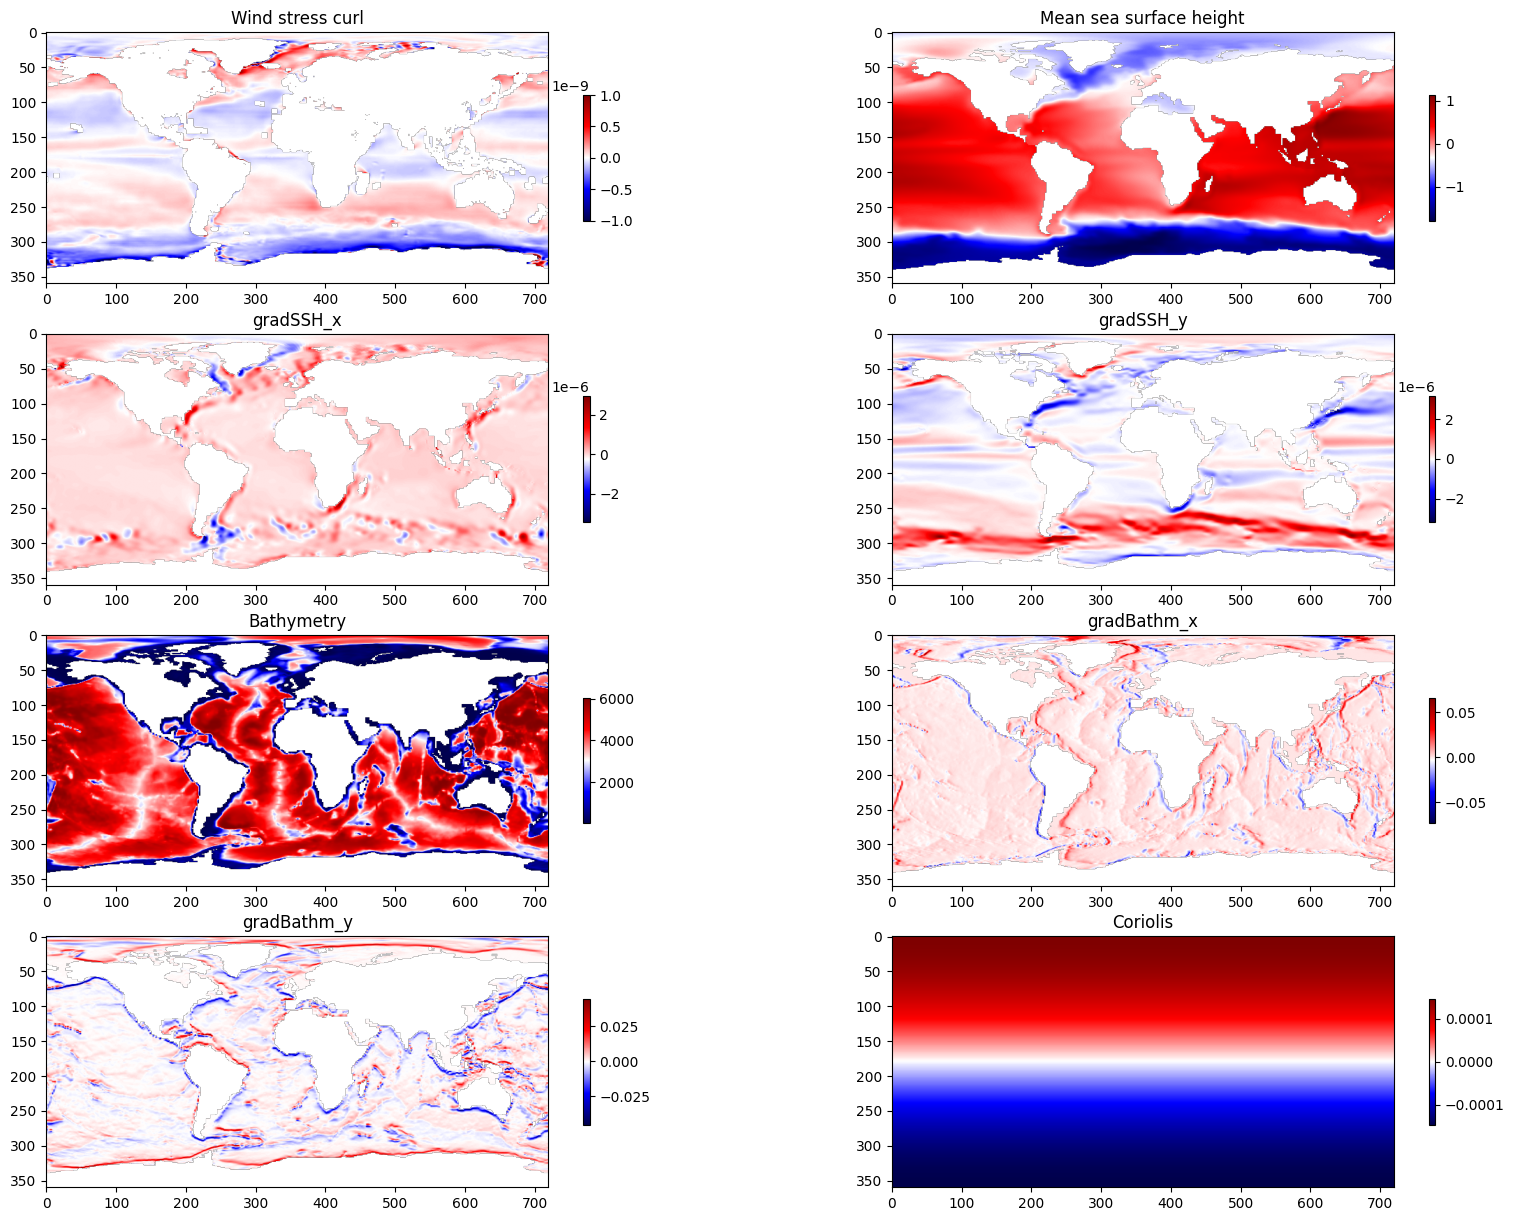

In [ ]:
## Plot data

plt.figure(figsize=(20,15))

plt.subplot(4,2,1)
plt.imshow(np.flipud(wind_stress_curl), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.clim(-1e-9,1e-9)
plt.title('Wind stress curl')

plt.subplot(4,2,2)
plt.imshow(np.flipud(SSH20mean), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('Mean sea surface height')

plt.subplot(4,2,3)
plt.imshow(np.flipud(gradSSH_x), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('gradSSH_x')

plt.subplot(4,2,4)
plt.imshow(np.flipud(gradSSH_y), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('gradSSH_y')

plt.subplot(4,2,5)
plt.imshow(np.flipud(bathymetry), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('Bathymetry')

plt.subplot(4,2,6)
plt.imshow(np.flipud(gradBathm_x), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('gradBathm_x')

plt.subplot(4,2,7)
plt.imshow(np.flipud(gradBathm_y), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('gradBathm_y')

plt.subplot(4,2,8)
plt.imshow(np.flipud(f), cmap='seismic')
plt.colorbar(shrink=0.5)
plt.title('Coriolis')

plt.show()

## Create training and test sets

In this section we will prepare the data set for the model - by creating training and testing sets and standardising the data. In the following code cell we will do two things:

1. Flag any points that have missing (NaN) values in any of the predictor variables. These will be excluded from the data set.
2. Create masks to define training and test datasets. The training set will include all ocean points except (roughly) the Atlantic Ocean. The test set is the inverse, including only the Atlantic Ocean.

In [ ]:
## Mask land pixels and other noisy locations
missingdataindex = np.isnan(wind_stress_curl*SSH20mean*gradSSH_x*gradSSH_y*bathymetry*gradBathm_x*gradBathm_y)

## Training data is ocean dataset excluding the Atlantic Ocean
maskTraining = (~missingdataindex).copy()
maskTraining[:,200:400]=False

## Test dataset is Atlantic Ocean dataset
maskTest = (~missingdataindex).copy()
maskTest[:,list(range(200))+list(range(400,720))]=False

We now use these masks to compile the full, training and test datasets. The output of this cell also gives the dimensions of the resulting arrays.

In [ ]:
## Set up training and test datasets

TotalDataset = np.stack((wind_stress_curl[~missingdataindex],
                         SSH20mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         bathymetry[~missingdataindex],
                         gradBathm_x[~missingdataindex],
                         gradBathm_y[~missingdataindex],
                         f[~missingdataindex]),1)

TrainDataset = np.stack((wind_stress_curl[maskTraining],
                         SSH20mean[maskTraining],
                         gradSSH_x[maskTraining],
                         gradSSH_y[maskTraining],
                         bathymetry[maskTraining],
                         gradBathm_x[maskTraining],
                         gradBathm_y[maskTraining],
                         f[maskTraining]),1)

TestDataset = np.stack((wind_stress_curl[maskTest],
                         SSH20mean[maskTest],
                         gradSSH_x[maskTest],
                         gradSSH_y[maskTest],
                         bathymetry[maskTest],
                         gradBathm_x[maskTest],
                         gradBathm_y[maskTest],
                       f[maskTest]),1)

print(TotalDataset.shape, TrainDataset.shape, TestDataset.shape)

train_label = ecco_label[maskTraining]
test_label = ecco_label[maskTest]
print(train_label.shape, test_label.shape)

(149587, 8) (109259, 8) (40328, 8)
(109259,) (40328,)


The final step here is to standardise the data so that each variable has mean zero and unit variance. This ensures that variables are on a similar scale, and improves the model performance and stability.

In [ ]:
## Scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(TrainDataset)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(TrainDataset)
X_test_scaled = scaler.transform(TestDataset)

Our data is finally ready for modelling. To build the Bayesian Neural Network (BNN) we'll be using both `tensorflow` and `tensorflow_probability` (imported previously). We will also convert the target labels into a one-hot encoded format which is suitable for tensorflow.

In [ ]:
# aliases for some modules
tfd = tfp.distributions
tfpl = tfp.layers

# convert target labels to appropriate data type for tensorflow
Y_train = tf.keras.utils.to_categorical(train_label)
Y_test = tf.keras.utils.to_categorical(test_label)

## Deterministic model

To begin with we will build a standard feedforward neural network where the parameters are fixed values, i.e. a deterministic model. Our model takes the eight predictor variables as inputs, and processes it through several hidden layers. The final layer uses a softmax function to classify the result into one of the six ocean circulation regimes.

The data is shaped for a gridpoint-by-gridpoint approach so dense layers are appropriate here. The following function defines the model using a sequential approach, and it is fitted to the training data in the next step.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop

In [ ]:
def deterministic_model():
    model = Sequential([
      Dense(input_shape = (8,), units =24,
                            activation = tf.keras.activations.tanh),
      Dense(units =24, activation = tf.keras.activations.tanh),
      Dense(units =16, activation = tf.keras.activations.tanh),
      Dense(units =16, activation = tf.keras.activations.tanh),
      Dense(units =6, activation = tf.keras.activations.softmax),
      ])
    return model


It's now time to train the model on the training data. We have to configure how the model will be trained. We specify:

- The *categorical cross-entropy* loss function, which quantifies the difference between the model class predictions and the true labels.
- The *categorical accuracy* metric is simply a metric which is reported during training to help monitor and evaluate the model performance.
- The optimiser is specified as the *Adam optimiser*, with learning rate 0.01.

We also specify how the model will be trained:

- Batch size of 32
- Number of epochs is 10

The batch size, number of epochs, optimiser type and configuration can all affect the performance of the model and are considered *hyperparameters*. We could potentially adjust these to see if model performance could be improved, but we leave that as an exercise for the reader.

In [ ]:
# Compile and fit the deterministic model
det_model = deterministic_model()
det_model.summary()
det_model.compile(loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
det_model.fit(X_train_scaled, Y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_split = 0.2, shuffle = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                216       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1590 (6.21 KB)
Trainable params: 1590 (6.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
2732/2732 [==

Having fitted the model, we check its accuracy. We feed both the training and test data into the model.

In [ ]:
# Evaluate the accuracy of this deterministic model

print(det_model.evaluate(X_train_scaled, Y_train))
print(det_model.evaluate(X_test_scaled, Y_test))

3415/3415 [==============================] - 5s 1ms/step - loss: 0.3486 - categorical_accuracy: 0.8832
[0.3486475646495819, 0.8832132816314697]
1261/1261 [==============================] - 2s 1ms/step - loss: 0.5557 - categorical_accuracy: 0.7981
[0.5557481646537781, 0.7981055378913879]


The main metric of interest here is the performance on the test set. This shows a categorical accuracy of about 77-80% (this will vary each time the model is trained, due to the randomness built in to the training process, e.g. sampling).

## Probabilistic model

In this section we will extend our model so that it provides a *probabilistic output* rather than deterministic categories, quantifying the aleatoric uncertainty. In the model specification this simply means replacing the softmax output layer from the previous model with a "OneHotCategorical" Layer from Tensorflow probability. As a result, the output of the network is a distribution rather than a categorical value. However, the weights and biases are still fixed parameters, so the model is not yet fully Bayesian (we build the full Bayesian model in the next section).

In [ ]:
def probabilistic_model():
    inputs = Input(shape=(8,))
    x = Dense(units=24, activation=tf.keras.activations.tanh)(inputs)
    x = Dense(units=24, activation=tf.keras.activations.tanh)(x)
    x = Dense(units=16, activation=tf.keras.activations.tanh)(x)
    x = Dense(units=16, activation=tf.keras.activations.tanh)(x)
    logits = Dense(units=6, activation=None)(x)
    outputs = tfpl.OneHotCategorical(6)(logits)

    model = Model(inputs=inputs, outputs=outputs)
    return model

prob_model = probabilistic_model()
prob_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_5 (Dense)             (None, 24)                216       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 16)                400       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 6)                 102       
                                                                 
 one_hot_categorical (OneHo  ((None, 6),               0     

We now fit the model to the training data as we did in the last example. A difference here though is that we have to define a new loss function which calculates the loss between the *probabilistic* output of the model and the true labels. Our loss function is the negative log-likelihood function, which calculates the log probability of the true labels under the predicted distribution `y_pred.log_prob(y_true)` and then negates it to get the negative log-likelihood.

In other respects, the configuration of the model training is similar to before.

In [ ]:
# define the negative log-likelihood function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

prob_model.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

prob_model.fit(X_train_scaled, Y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split = 0.2, shuffle = True)

Epoch 1/20
2732/2732 [==============================] - 8s 2ms/step - loss: 0.3893 - accuracy: 0.7915 - val_loss: 0.7627 - val_accuracy: 0.7069
Epoch 2/20
2732/2732 [==============================] - 6s 2ms/step - loss: 0.3175 - accuracy: 0.8330 - val_loss: 0.5796 - val_accuracy: 0.7345
Epoch 3/20
2732/2732 [==============================] - 10s 4ms/step - loss: 0.3069 - accuracy: 0.8387 - val_loss: 0.6163 - val_accuracy: 0.7351
Epoch 4/20
2732/2732 [==============================] - 7s 3ms/step - loss: 0.3027 - accuracy: 0.8394 - val_loss: 0.5682 - val_accuracy: 0.7595
Epoch 5/20
2732/2732 [==============================] - 6s 2ms/step - loss: 0.2972 - accuracy: 0.8429 - val_loss: 0.6595 - val_accuracy: 0.7368
Epoch 6/20
2732/2732 [==============================] - 6s 2ms/step - loss: 0.2895 - accuracy: 0.8476 - val_loss: 0.5717 - val_accuracy: 0.7805
Epoch 7/20
2732/2732 [==============================] - 6s 2ms/step - loss: 0.2890 - accuracy: 0.8461 - val_loss: 0.5995 - val_accuracy

An example of the output of this trained model is given below. Each value in the array gives the estimated probability of the input data point belonging to each of the six ocean circulation regimes.

In [ ]:
## Example output
prob_model(X_test_scaled[0:1]).mean().numpy()

array([[2.23020121e-04, 6.34492701e-03, 6.81366203e-07, 2.56378025e-01,
        1.03569975e-04, 7.36949801e-01]], dtype=float32)

As before, we will evaluate the accuracy of the model.

In [ ]:
# Evaluate the accuracy of this first Bayesian model

print(prob_model.evaluate(X_train_scaled, Y_train))
print(prob_model.evaluate(X_test_scaled, Y_test))

3415/3415 [==============================] - 5s 1ms/step - loss: 0.3630 - accuracy: 0.8366
[0.3630378544330597, 0.8365535140037537]
1261/1261 [==============================] - 2s 1ms/step - loss: 0.5692 - accuracy: 0.7627
[0.5691739320755005, 0.7626959085464478]


## Probabilistic model (epistemic)

In this section we will further extend our model to quantify epistemic uncertainty as well as aleatoric uncertainty. This means that the weights and biases of the model will now be treated as random variables, rather than fixed parameters. Building a Bayesian model requires defining prior distributions of these trainable parameters.

Our goal is to find the posterior distributions of these parameters, and this will be done with *variational inference*, which is a technique in Bayesian statistics used to approximate complex probability distributions, especially when exact inference is computationally intractable. Varational inference requires additionally specifying a distribution type for the posterior, so we have to define this as well.

The following function specifies the prior distribution for the weights and biases in one of the layers of our model. It uses a multivariate normal distribution with mean zero and standard deviation 1. This assumes that parameters are independent.

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = Sequential([
                            tfpl.DistributionLambda(
                                lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
                            )
    ]) # normal distribution for each weight in the layer
    return prior_model

This next function defines the type of the posterior distribution of the parameters in a layer, for the purposes of variational inference. The posterior is assumed to be shaped as a multivariate normal distribution - the task will be to learn the parameters of this distribution (means and variances).

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
                tfpl.VariableLayer(2*n, dtype=dtype),
                tfpl.DistributionLambda (
        lambda t: tfd.MultivariateNormalDiag(loc = t[..., :n], scale_diag = tf.math.exp(t[..., n:])))
    ]) # define posterior for each weight in the layer
    return posterior_model

Now we can define the model. The `Dense` layers used in the previous models are replaced with `DenseVariational` layers from `tensorflow_probability`. In each layer, we specify the prior and posterior distributions using the functions defined previously. The shape of the model is however similar to the previous models: the hidden layers have 24, 24, 16, and 16 units, while the final layer has 6 units, corresponding to the number of ocean circulation regimes.

There is a technical issue here: variational inference uses the Kullback-Leibler divergence to quantify the difference between the approximate posterior and the prior, encouraging the model's learned parameters to stay relatively close to the prior values. We have to scale the KL distance by the reciprocal of the number of training samples to ensure it is balanced with the negative log-likelihood. This is specified in the `kl_weight` argument.

In [ ]:
def bnn():
  model = Sequential([
    tfpl.DenseVariational(input_shape = (8,), units =24,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =24,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =16,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =16,
                          activation = tf.keras.activations.tanh,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
    tfpl.DenseVariational(units =6,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight = 1/X_train_scaled.shape[0], # have to rescale the kl_error
                          kl_use_exact=True # use if have analytic form of prior and posterior - may error in which case change to False
                          ),
   tfpl.OneHotCategorical(6)])
  return model

Next we will specify how the model should be trained:

- We use the negative log-likelihood function as the loss function.
- We compile the model, specifying the optimiser and learning rate.
- We add "callbacks", which are functions executed at specific stages of the training process. In this case, `checkpoint_callback` saves the model weights after each epoch, and `reduce_lr_callback` adjusts the learning rate based on the validation loss, in order to improve convergence.

In [ ]:
bnn_model = bnn()

# negative log-likelihood as loss function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

bnn_model.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

# add callbacks to save best weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'bnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')

# and to reduce the learning rate if the error does not improve after 15 epochs
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=15,
            factor=0.25,
            verbose=1)

Finally we can train the model. Here we will use a maximum of 100 epochs due to the increased complexity of the model, so this may take some time to train.

In [ ]:
# fit model
bnn_model.fit(X_train_scaled, Y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint_callback, reduce_lr_callback])

Epoch 1/100
2716/2732 [============================>.] - ETA: 0s - loss: 2.0595 - accuracy: 0.2086
Epoch 1: val_loss improved from inf to 1.65217, saving model to bnn_weights.h5
2732/2732 [==============================] - 14s 3ms/step - loss: 2.0575 - accuracy: 0.2087 - val_loss: 1.6522 - val_accuracy: 0.2247 - lr: 0.0100
Epoch 2/100
2719/2732 [============================>.] - ETA: 0s - loss: 1.6896 - accuracy: 0.2134
Epoch 2: val_loss improved from 1.65217 to 1.61870, saving model to bnn_weights.h5
2732/2732 [==============================] - 7s 2ms/step - loss: 1.6896 - accuracy: 0.2135 - val_loss: 1.6187 - val_accuracy: 0.2280 - lr: 0.0100
Epoch 3/100
2725/2732 [============================>.] - ETA: 0s - loss: 1.2785 - accuracy: 0.3472
Epoch 3: val_loss improved from 1.61870 to 1.56400, saving model to bnn_weights.h5
2732/2732 [==============================] - 8s 3ms/step - loss: 1.2775 - accuracy: 0.3475 - val_loss: 1.5640 - val_accuracy: 0.3342 - lr: 0.0100
Epoch 4/100
2718/27

Now to evaluate the accuracy.

In [ ]:
# Evaluate the accuracy of the BNN model

print(bnn_model.evaluate(X_train_scaled, Y_train))
print(bnn_model.evaluate(X_test_scaled, Y_test))

3415/3415 [==============================] - 6s 2ms/step - loss: 0.3577 - accuracy: 0.8503
[0.3576786518096924, 0.8503464460372925]
1261/1261 [==============================] - 2s 2ms/step - loss: 0.5637 - accuracy: 0.7633
[0.5637413263320923, 0.7633157968521118]


## Plotting uncertainty metrics

Below we provide some functions to plot the results of the BNN and assess its performance.

- The `boxplot_model_predictions` function visualizes the probabilistic output of the BNN for a specific data point, and reports the true class.
- The `get_correct_indices function` identifies which data points were correctly and incorrectly classified by the BNN based on the mean of the predicted probabilities.
- The `plot_entropy_distribution` function visualizes the distribution of entropy for the correctly and incorrectly classified data points. Entropy is used as a measure of uncertainty; higher entropy indicates higher uncertainty in the model's prediction.

In [ ]:
# Define functions to analyse model predictions versus true labels

def boxplot_model_predictions(prob_predictions, point_num, labels, run_ensemble = True):

    # Mapping from numerical labels to text labels
    class_labels = {
        0: "F",
        1: "E",
        2: "D",
        3: "C",
        4: "B",
        5: "A"
    }

    # Get the numerical true label for the given point
    numerical_true_label = labels[point_num]

    # Print the true activity
    print('------------------------------')
    # Check if the numerical label is valid (not NaN, which indicates land)
    if not np.isnan(numerical_true_label):
        print('True cluster:', class_labels[int(numerical_true_label)])
    else:
        print('True cluster: Land (NaN)')
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities

    predicted_probabilities = prob_predictions[:, point_num, :]
    box = plt.boxplot(predicted_probabilities, positions = [0, 1, 2, 3, 4, 5])
    for i in range(6):
        if i == int(labels[point_num]):
            plt.setp(box['boxes'][i], color='green')
            plt.setp(box['medians'][i], color='green')
        else:
            plt.setp(box['boxes'][i], color='purple')
            plt.setp(box['medians'][i], color='purple')
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.xticks([0, 1, 2, 3, 4, 5], ["F", "E", "D", "C", "B", "A"])
    plt.xlim([5.5, -0.5])
    plt.show()
    return predicted_probabilities

def get_correct_indices(prob_mean, labels):
    correct = np.argmax(prob_mean, axis=1) == np.argmax(labels, axis = 1)
    correct_indices = [i for i in range(prob_mean.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(prob_mean.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices

def plot_entropy_distribution(prob_mean, labels):
    entropy = -np.sum(prob_mean * np.log2(prob_mean), axis=1)
    corr_indices, incorr_indices = get_correct_indices(prob_mean, labels)
    indices = [corr_indices, incorr_indices]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = np.array([entropy[j] for j in indices[i]])
        mean_entropy = np.mean(entropy_category[~np.isnan(entropy_category)])
        num_samples = entropy_category.shape[0]
        #title = category + 'ly labelled ({:.2f}% of total)'.format(num_samples / x.shape[0] * 100)
        title = category + 'ly labelled'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f}'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy')
        axes[i].set_ylim([0, 1])
        #axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
        print(num_samples)
    plt.show()

To use these plotting functions, we generate an ensemble of 200 predictions for the test data set.

In [ ]:
# Generate ensemble of predictions from the BNN

ensemble_size = 200
x = X_test_scaled

prob_predictions = np.empty(shape=(ensemble_size, 40328, 6))
for i in range(ensemble_size):
    prob_predictions[i] = bnn_model(x).mean().numpy()

prob_mean = prob_predictions.mean(axis = 0)

# reshape array
pred = np.nan * np.zeros((360*720))
pred[maskTest.flatten()] = prob_mean.argmax(axis = 1)

We also find indices for which the BNN was correct (`c_in`) and incorrect (`inc_in`).

In [ ]:
# find indices of datapoints for which the neural network is correct and indices for which it is incorrect
c_in, inc_in = get_correct_indices(prob_mean, Y_test)

### Classification box plots

We can plot two instances where the BNN was correct, and two where it was not correct.

------------------------------
True cluster: F

------------------------------
Model estimated probabilities:


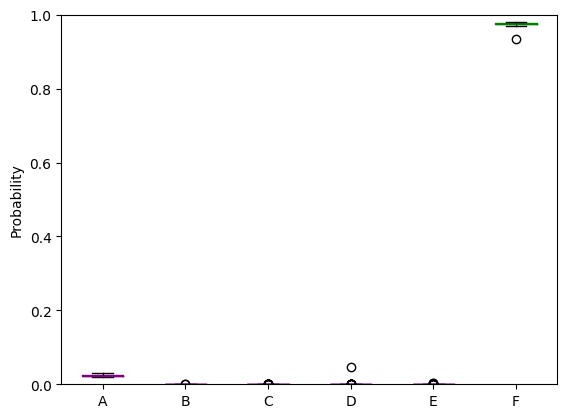

------------------------------
True cluster: D

------------------------------
Model estimated probabilities:


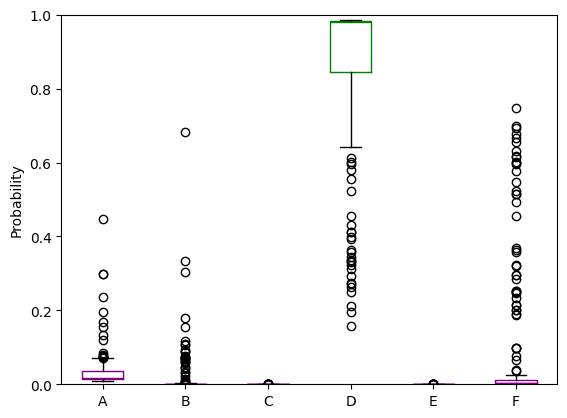

------------------------------
True cluster: C

------------------------------
Model estimated probabilities:


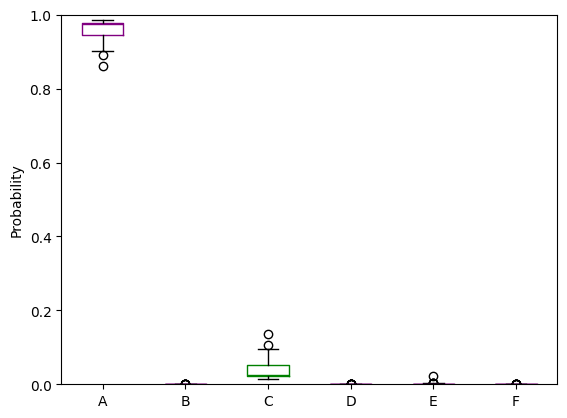

------------------------------
True cluster: A

------------------------------
Model estimated probabilities:


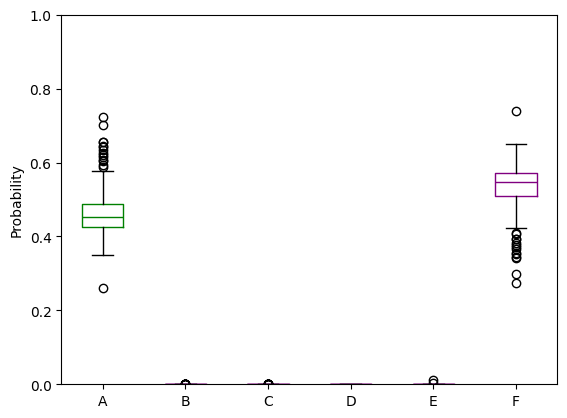

In [ ]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)

## two correct prediction
corr_0 = boxplot_model_predictions(prob_predictions, c_in[107*200], test_label, run_ensemble = True)
corr_1 = boxplot_model_predictions(prob_predictions, c_in[75*200], test_label, run_ensemble = True)

## two incorrect predictions
incorr_0 = boxplot_model_predictions(prob_predictions, inc_in[100], test_label, run_ensemble = True)
incorr_1 = boxplot_model_predictions(prob_predictions, inc_in[200], test_label, run_ensemble = True)

# Note in these box and whisker plots the distributions themselves represent the aleatoric uncertainty
# and the box and whiskers (ie. the ensemble of possible distributions) represent the epistemic uncertainty

### Entropy

Model uncertainty can be quantified by calculating the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The higher the value, the more unsure the model is. The following code plots the entropy on a map.



In [ ]:
! pip install Basemap # note you may have this already installed and therefore do not need to run this line

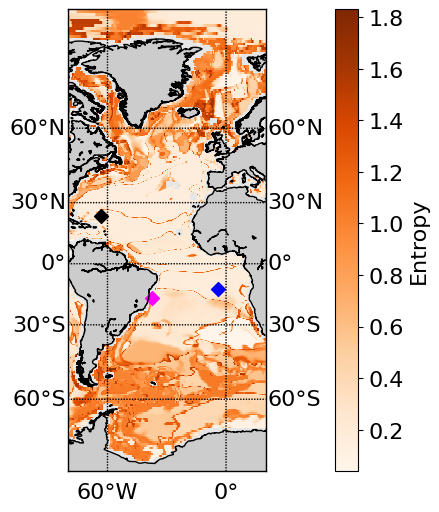

In [ ]:
from mpl_toolkits.basemap import *

plt.rcParams.update({'font.size': 16})

entropy = -np.sum(prob_mean* np.log2(prob_mean), axis=1)
all_results = np.nan * np.zeros((360*720))
all_results[maskTest.flatten()] = entropy
lat = monthly_ssh['lat']
lon = monthly_ssh['lon']
lons = lon[1,:].values
lats = lat[:,1].values
llons, llats = np.meshgrid(lons,lats)
fig, ax = plt.subplots(figsize = (12, 6))
m = Basemap(llcrnrlon=-80, urcrnrlon=20, llcrnrlat=-80, urcrnrlat=89, projection='mill', resolution='l')
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.drawcoastlines()
m.fillcontinents()
im1 = m.pcolor(llons, llats, np.flipud(np.reshape(all_results,(360,720)))[::-1,:], latlon=True, cmap = plt.cm.Oranges)
cbar = plt.colorbar(pad=0.075)
cbar.set_label('Entropy')
im2 = m.scatter([-63.25], [23.75], marker = 'D', c = 'black',  s = 50, latlon = True)
im3 = m.scatter([-4.25], [-12.75], marker = 'D', c = 'blue',  s = 50, latlon = True)
im4 = m.scatter([-37.25], [-17.25], marker = 'D', c = 'magenta', s = 50, latlon = True)
plt.show()



32610
7718


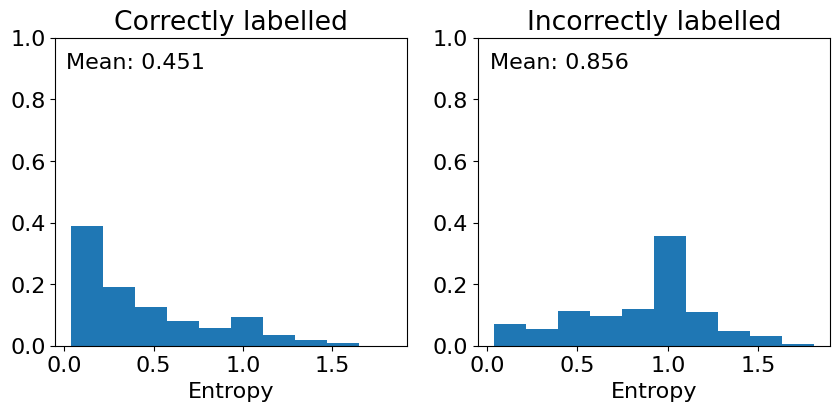

In [ ]:
plot_entropy_distribution(prob_mean, Y_test)

This shows that indeed, the entropy is higher on average for incorrect classifications than for correct ones.

There are also many other interesting plots that can be produced from BNN predictions as shown in Clare et al. 2022.
The code to make these plots is at the end of this [notebook on github](https://github.com/maikejulie/DNN4Cli/blob/main/THOR/BayesianApproach/THOR%20-%20Step_2_Bayesian_approach.ipynb)